In [1]:
from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
!pip install mglearn
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler
%matplotlib inline
from sklearn.model_selection import train_test_split

機械学習の最終的な目標
---
- 機械学習の基準を選ぶ前にそのアプリケーションの高レベルでの目的を考える必要がある
    - これは「ビジネス評価基準(bisiness metric)」と呼ばれる
- 機械学習アプリケーションに対して特定のアルゴリズムを選択した結果は「ビジネスインパクト(business impact)と呼ばれる


2クラス分類における基準
---
- 2クラス分類において2つのクラスを`陽性`クラスと`陰性`クラスと呼び、探しているものを陽性と呼ぶ

### エラーの種類
例として、自動テストで癌の早期発見を行うアプリケーションで考える

- テストが陰性であれば健康、陽性であればさらなる検査に回される
- エラー1: 健康な患者を陽性に分類する
    - 間違った陽性との分類を「偽陽性(false positive)」と呼ぶ
    - 統計学では「タイプⅠエラー」と呼ぶ
- エラー2: 病気の患者を陰性と分類する
    - 間違った陰性との分類を「偽陰性(false negative)」と呼ぶ
    - 統計学では「タイプⅡエラー」と呼ぶ
- 癌の診断の場合、偽陰性を可能な限り避けるべきなのは明らか、偽陽性はそれほど問題ではない

### 偏ったデータセット
- エラーのタイプは、2つのクラスが一方よりもう一方の方がずっと多い場合に重要になる
- 一方のクラスが他方のクラスよりもずっと多いようなデータセットを「偏ったデータセット(imbalanced datasets)」もしくは「偏ったクラスのデータセット(datasets with imbalanced classes)」と呼ぶ
    - 実際には偏ったデータがほとんどで、頻度が同じだったり近かったりするようなデータは珍しい
    

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

In [3]:
from sklearn.dummy import DummyClassifier
# most_frequentは常に一番多数のクラスを予測値として返す
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


- 上記では、digitsデータセットの数字を9と9以外の数字に分類している
- DummyClassifierは常に「9以外(多数のクラス)」を予測するように設定されている
- この結果は何もしなくても90%でる

In [5]:
from sklearn.linear_model import LogisticRegression

#  ダミーはランダムで予測する
dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.80
logreg score: 0.98


- ランダムで出力するダミーのほうが当然スコアは低いが、それでも80%の精度がでている

### つまり、偏ったデータに対する予測性能を定量化する基準として、精度をつかうことは不適切だとうことがわかる

混同行列
---
- 2クラス分類の評価結果を表現する方法で、最も包括的な方法の一つとして混同行列(confusion matrix)がある


In [6]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


- confusion_matrixの出力は2*2の配列になっている
- 行は実際のクラスに対応し、列は予測されたクラスに対応する
    - 上記の例だと、1行目が「9以外」、2行目が「9」
    -　1列目が、「9以外だと予測されたもの」2列目が「9だと予測されたもの」

||predicted negative|predictred positive|
|--|--|--| 
|nagative class |TN(true negative)|FP(false positive)|
|positive class |FN(false negative)|TP(true positive)|

In [9]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[374  29]
 [ 44   3]]

Logistic Regression
[[401   2]
 [  8  39]]


- pred_most_frequentは、常にひとつのクラスを予測しているので結果がおかしい
- pred_dummyは真陽性よりも偽陽性のほうが多い

精度との関係
---

- すべてのサンプル数の中で正確な予測ができたものの割合

$$
精度 = \frac{TP + TN}{TP + TN + FP + FN}
$$

適合率
---

- 適合率(precision)は、陽性であると予測されたものがどのくらい実際に陽性であったかを測定する

$$
適合率 = \frac{TP}{TP + FP}
$$

- 適合率は、偽陽性の数を制限したいときに使われる
- 例えば、新薬の臨床試験の結果など、実際に高価があることを確信していない限り臨床実験を行いたくないような場合に重要な指標となる
- 適合率は、PPV(positive predictive value: 陽性的中率)とも呼ばれる

再現率
---
- 再現率(recall)は、実際に陽性のサンプルのうち、陽性と予測されたものの割合と定義される
    - 偽陰性を避けることが重要な場合の指標

$$
再現率 = \frac{TP}{TP + FN}
$$

- 例えば、癌の診断など。癌である人を漏らさずすべて見つけることがが重要で、健康な人を癌だと予測してしまっても構わない。(FP)
- 再現率は、感度(sensitivity),ヒット率(hit rare)、真陽性率(true positive rate: TPR)とも呼ばれる

再現率と適合率の関係
---
- 再現率と適合率はトレードオフの関係にある
- 再現率を高めるには、すべてのサンプルを陽性クラスと判定すればよい。しかし、そうすると大量の偽陽性が発生し、適合率は非常に低くなる
- 逆に、真であることが最も確信できるデータポイントを1点だけ陽性と予測し残りを陰性と予測するようなモデルの場合、適合率は100%になるが、再現率は非常に低くなる

f-値
---
- 適合率と再現率を2つまとめて評価する方法としてf-値(f-measure)がある
- これは、適合率を再現率の調和平均

$$
F = 2 × \frac{適合率 × 再現率}{適合率 + 再現率}
$$

- これは、f-値の変種の一つであり「f1-値」とも呼ばれる

In [12]:
from sklearn.metrics import f1_score
print(f"f1 score most frequent: {f1_score(y_test, pred_most_frequent):.2f}")
print(f"f1 score logistic regression: {f1_score(y_test, pred_logreg):.2f}")

f1 score most frequent: 0.00
f1 score logistic regression: 0.89


/Users/amoro/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


- pred_most_frequentについては、陽性クラスと予測されるサンプルがないためエラーが出る
- f-値の問題点は精度と比べると解釈や説明が難しいこと

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.90      1.00      0.94       403
       nine       0.00      0.00      0.00        47

avg / total       0.80      0.90      0.85       450



/Users/amoro/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


- 適合率、再現率、f-値を包括的なレポートで確認するためには、classfication_report関数を使うとよい

In [14]:
print(classification_report(y_test, pred_dummy, target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.89      0.93      0.91       403
       nine       0.09      0.06      0.08        47

avg / total       0.81      0.84      0.82       450



In [15]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.98      1.00      0.99       403
       nine       0.95      0.83      0.89        47

avg / total       0.98      0.98      0.98       450



- 上記の呼び出しでは、9以外を陽性としている
- レポートからは、ダミーもでるとロジスティック回帰ではあまり違いが明確ではなくなってしまっている
- どちらを陽性にするかどうかで値が大きく変わっている

不確実性の考慮
---
- ほとんどのクラス分類機には予測の不確実性を評価するための`decision_function`や`predict_proba`関数が用意されている
- 予測をおこなうということは、decision_functionやpredict_probaの出力を固定したスレッショルド(しきい値)で分けることに相当する
    - decision_functionは0、predict_probaは0.5が初期値

In [18]:
from mglearn.datasets import make_blobs
from sklearn.svm import SVC
    
X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

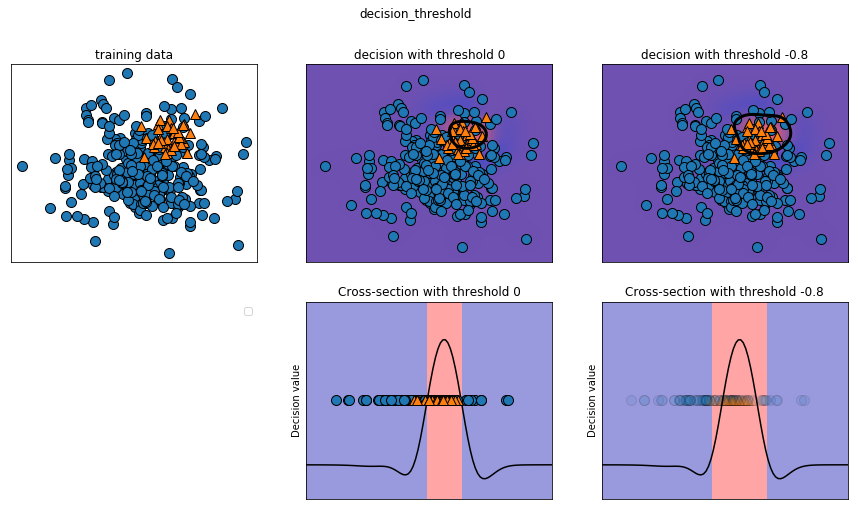

In [19]:
mglearn.plots.plot_decision_threshold()

In [21]:
print(classification_report(y_test, svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       104
          1       0.35      0.67      0.46         9

avg / total       0.92      0.88      0.89       113



- クラス1に関しては、再現率は低く、適合率も微妙な値
- クラス1はサンプル数が少ないため、識別がうまくいっていない
- クラス1の再現率を高めることが重要だとした場合、偽陽性が増えても構わない
- 決定スレッショルドを0から動かすことでクラス1の再現率が高くなるように予測を調整するこが可能

In [22]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [23]:
print(classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90       104
          1       0.32      1.00      0.49         9

avg / total       0.95      0.83      0.87       113



- predict_probaメソッドを実装しているモデルであればスレッショルドは比較的カンタンに設定できる
- predict_probaは0~1までの確率を表現しているため